# Project: Medical Appointment No-Shows Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

We'll be using data collected about 100k medical appointments in Brazi. The purpose of the data is to identify possible correlations between patients not showing up their appointments and various health and scheduling factors. 

The data has the following fields:

- `PatientId`: Identification of a patient. 
- `AppointmentID`: Identification of each appointment
- `Gender`: Male or Female
- `ScheduledDay`: The day someone called or registered the appointment, should be before the appointment.
- `AppointmentDay`: The day of the actual appointment, when they have to visit the doctor.
- `Age`: How old is the patient.
- `Neighbourhood`: Where the appointment takes place.
- `Scholarship`: True of False . Whether the patient is part of the Bolsa Familia Scholorship Program https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia
- `Hypertension`: True or False
- `Diabetes`: True or False
- `Alcoholism`: True or False
- `Handicap`: True or False
- `SMS_received`: 1 or more messages sent to the patient.
- `No-show`: True or False. This is the primary dependent variable.



### Question(s) for Analysis

For this analysis we'll concern ourselves with two questions:

- What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?
- Is there a difference in no-shows between repeat and first-time patients?

### Approach

We'll go through the following steps to build our analysis:

- Review general characteristics of the data - shape, summary statistics, data types, missing values, value counts of certain fields.
- Decide on data cleaning and wrangling that may be required.
- Perform identified data wranlging and cleaning steps. Save a cleaned version of the dataset.
- Using the cleaned dataset to perform an exploratory data analysis answering our two primary questions.
- Finalise the analysis with conclusions and limitations observed.


In [487]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [488]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Data issues: 
- Would prefer column names to be lowercase and with correct spelling (Hipertension)
- `No-show` field will be awkward to work with so will change to use '_' instead of '-'. This should be consistant across all fields
- Would like to seperate dates into year, month day columns
- No-show is the dependent variable, so important to see what unique values it contains to ensure there are no missing/unusual values

In [489]:
df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

`No` means they did show for appointment and `Yes` means they didn't. This is a little confusing so must keep it in mind throughout the analysis.

In [490]:
df.shape

(110527, 14)

In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Following issues should be addressed:
- `PatientId` should probably be an int like `AppointmentID` and both should be consistantly named as {prefix}ID
- `ScheduleDay` and `AppointmentDay`should be converted to datetime
- `No-show` could be converted to a 0/1 value to be consistent with the rest of the data

In [492]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

No missing values however I do want to ensure there are no unusual values within the categorical variables as these could skew the analysis

In [493]:
df['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [494]:
df['Neighbourhood'].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

In [495]:
df['Scholarship'].value_counts()

0    99666
1    10861
Name: Scholarship, dtype: int64

In [496]:
df['Hipertension'].value_counts()

0    88726
1    21801
Name: Hipertension, dtype: int64

In [497]:
df['Diabetes'].value_counts()

0    102584
1      7943
Name: Diabetes, dtype: int64

In [498]:
df['Alcoholism'].value_counts()

0    107167
1      3360
Name: Alcoholism, dtype: int64

In [499]:
df['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [500]:
df['SMS_received'].value_counts()

0    75045
1    35482
Name: SMS_received, dtype: int64

`PatientId` and `AppointmentID` generally wouldn't carry much value, howerver, if we want to assess if any repeat patients consistently miss appointment, then it will be good to see if `PatiendId` actually occurs more than once in the data. 

In [501]:
# referenced from https://stackoverflow.com/questions/54697138/group-by-having-count-in-pandas
df.groupby('PatientId', as_index=False)['PatientId'].agg({'count' : 'count'}).query('count > 1')

,PatientId,count
7,2.263866e+07,2
8,5.216894e+07,2
12,6.485121e+07,2
14,7.922850e+07,2
16,8.799645e+07,2
...,...,...
62285,9.996275e+14,4
62288,9.997437e+14,2
62291,9.998318e+14,4
62292,9.998774e+14,2


Clearly the have a lot of repeat patients, so we should keep this column, change it to an int and check no shows against first-time and repeat patients.

In [502]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


A few high-level observations:
- Age has a min value of 1, this must be a data capture error, so must be corrected
- Most people are under 55 years of age, so will be interested to see what proportion of no-shows come from this group versus the group above 55 years
- Most of the group does not have hypertension, diabetes, alcoholism or a handicap, as one might expect.
- Most of the group does not get a Bolsa Scholarship

Lets find the record with `Age` = -1

In [503]:
df.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No



### Data Cleaning
 

Based on the above, the following data cleaning steps will be taken:
- Ensure all column heaers are consistent: 1) lowercase 2) use underscores instead of dashes 3) Use ID insyead of Id as part of column names 4) use correct spelling for labels
- `PatientId` should be int
- `ScheduleDay` and `AppointmentDay`should be converted to datetime
- `ScheduleDay` and `AppointmentDay`should be split out into year, month, day and hour columns (minutes and seconds can be ignored)
- Correct the record with `Age` = -1
- `no_show` should be 0/1 to be consistent with the rest of the data
- drop columns that are not needed: `appointment_id`, `schedule_day`, `appointment_day` (as we've already extracted the day/month/year/hour from them)

#### Lowercase all columns

We'll rely on pandas Series functions to make all the columns lowercase

In [504]:
df.columns= df.columns.str.lower()
df.head(2)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


#### Rename columns

We'll rename columns such that: spelling errors are removed, words are split using an underscore. We'll use pandas for this.

In [505]:
col_dict = {"patientid": "patient_id", "appointmentid": "appointment_id", "scheduledday": "scheduled_day", "appointmentday": "appointment_day", "hipertension": "hypertension", "handcap": "handicap", "no-show" : "no_show"}
df.rename(columns=col_dict, inplace=True)
df.head(1)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


#### Convert column types


We'll change the data type of `patient_id` (int), `scheduled_day` (datetime) and `appointment_day` (datetime) to make them easier to work with.

In [506]:
print(df.patient_id.dtype)
df.patient_id = df.patient_id.astype(np.int64)
print(df.patient_id.dtype)

float64
int64


In [507]:
print(df.scheduled_day.dtype)
df.scheduled_day = pd.to_datetime(df.scheduled_day)
print(df.scheduled_day.dtype)

object
datetime64[ns, UTC]


In [508]:
print(df.appointment_day.dtype)
df.appointment_day = pd.to_datetime(df.appointment_day)
print(df.appointment_day.dtype)

object
datetime64[ns, UTC]


#### Change no_show from No/Yes to 0/1 to be consistent with the rest of the data

Reference https://www.geeksforgeeks.org/replace-the-column-contains-the-values-yes-and-no-with-true-and-false-in-python-pandas/

In [509]:
# referenced from https://www.geeksforgeeks.org/replace-the-column-contains-the-values-yes-and-no-with-true-and-false-in-python-pandas/
df = df.replace({'no_show': {'Yes': 1, 'No': 0}})
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0


In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       110527 non-null  int64              
 1   appointment_id   110527 non-null  int64              
 2   gender           110527 non-null  object             
 3   scheduled_day    110527 non-null  datetime64[ns, UTC]
 4   appointment_day  110527 non-null  datetime64[ns, UTC]
 5   age              110527 non-null  int64              
 6   neighbourhood    110527 non-null  object             
 7   scholarship      110527 non-null  int64              
 8   hypertension     110527 non-null  int64              
 9   diabetes         110527 non-null  int64              
 10  alcoholism       110527 non-null  int64              
 11  handicap         110527 non-null  int64              
 12  sms_received     110527 non-null  int64              
 13 

All columns now have the expected data types and formatting

#### Splitting out data columns

We'll split out hour/day/month/year values from our dates in order to better aggregate on those variables.

Reference https://stackoverflow.com/questions/55776571/how-to-split-a-date-column-into-separate-day-month-year-column-in-pandas

In [511]:
df['scheduled_date_year'] = df['scheduled_day'].dt.year
df['scheduled_date_month'] = df['scheduled_day'].dt.month
df['scheduled_date_day'] = df['scheduled_day'].dt.day
df['scheduled_date_hour'] = df['scheduled_day'].dt.hour

df['appointment_date_year'] = df['appointment_day'].dt.year
df['appointment_date_month'] = df['appointment_day'].dt.month
df['appointment_date_day'] = df['appointment_day'].dt.day
df['appointment_date_hour'] = df['appointment_day'].dt.hour

In [512]:
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,...,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,...,0,0,2016,4,29,18,2016,4,29,0
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,...,0,0,2016,4,29,16,2016,4,29,0
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,...,0,0,2016,4,29,16,2016,4,29,0
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,...,0,0,2016,4,29,17,2016,4,29,0
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,...,0,0,2016,4,29,16,2016,4,29,0


In [513]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   patient_id              110527 non-null  int64              
 1   appointment_id          110527 non-null  int64              
 2   gender                  110527 non-null  object             
 3   scheduled_day           110527 non-null  datetime64[ns, UTC]
 4   appointment_day         110527 non-null  datetime64[ns, UTC]
 5   age                     110527 non-null  int64              
 6   neighbourhood           110527 non-null  object             
 7   scholarship             110527 non-null  int64              
 8   hypertension            110527 non-null  int64              
 9   diabetes                110527 non-null  int64              
 10  alcoholism              110527 non-null  int64              
 11  handicap                11

#### Change `age` = -1 value to 0

We're going to assume that this age should be 0, i.e. a newborn and change it as such. An alternative step would be to remove the row completely.

In [514]:
df.query('age < 0')

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,...,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour
99832,465943158731293,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,...,0,0,2016,6,6,8,2016,6,6,0


In [515]:
df.loc[99832, 'age'] = 0

In [516]:
df.query('age < 0')

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,...,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour


#### Remove unneccessary columns

We're removing `appointment_id` as it has no relevance for our analysysis, as well as the original scheduled and applointment datetime fields, since we have already extracted the info we need from them into their own columns

In [517]:
df.drop(['appointment_id', 'scheduled_day', 'appointment_day'], axis=1, inplace=True)
df.head()

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour
0,29872499824296,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016,4,29,18,2016,4,29,0
1,558997776694438,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29,0
2,4262962299951,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29,0
3,867951213174,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016,4,29,17,2016,4,29,0
4,8841186448183,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016,4,29,16,2016,4,29,0


#### Save the cleaned data set for later reference

In [518]:
df.to_csv('cleaned_noshow_appointments.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1 - What factors are correlated with a now-show?

As  first step, let's get a sense of the distribution of the `no_show` field, beng our primary dependent variable

Text(0, 0.5, 'Count')

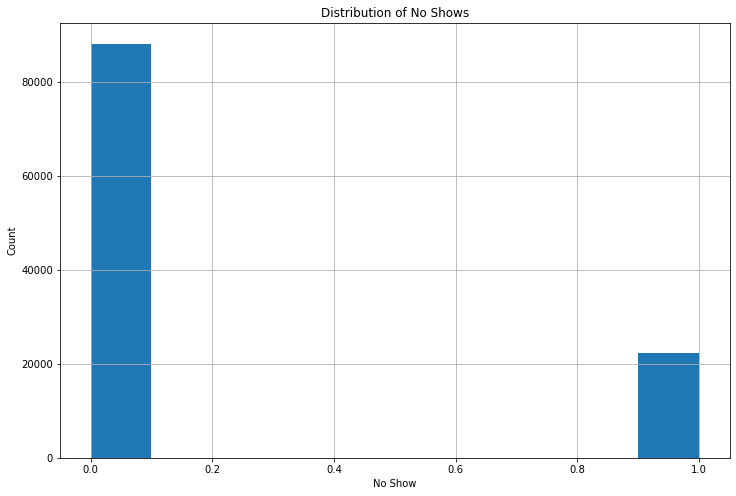

In [556]:
ax = df.no_show.hist(figsize=(12, 8))
ax.set_title('Distribution of No Shows')
ax.set_xlabel('No Show')
ax.set_ylabel('Count')

The majority of patients do in fact attend their consultations, as expected. Let's see what percentage of appointments are no shows

In [520]:
print(f'Percent of no shows: {df.query("no_show == 1").no_show.count()/df.shape[0]*100}')

Percent of no shows: 20.193255946510806


20% of all consulatations result in a no show, which is quite substantial.

The total number of no shows in the dataset

In [521]:
df.query('no_show == 1').no_show.count()

22319

Let's now get a broad sense of the distribution of variables and correlations, by looking at groups of variables at a time and using heatmaps. Reference: https://www.kaggle.com/drazen/heatmap-with-sized-markers

First, we'll isolate the categorical varaibles

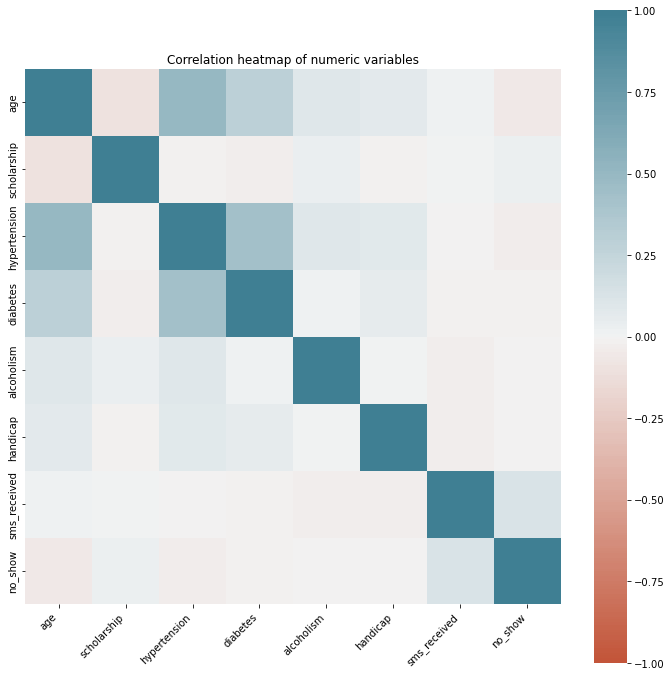

In [560]:
corr = df[['gender', 'age', 'neighbourhood', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show']].corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title('Correlation heatmap of numeric variables')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Not a very strong positive or negative correlation between no_show and these variables, however we can see some positive correlation between diabetes and hypertension, as well hypertension and age and diabetes and age. Slight positive correlation between receiving an sms about the appointment and a no show.

Now, we'll look at the date and time variables

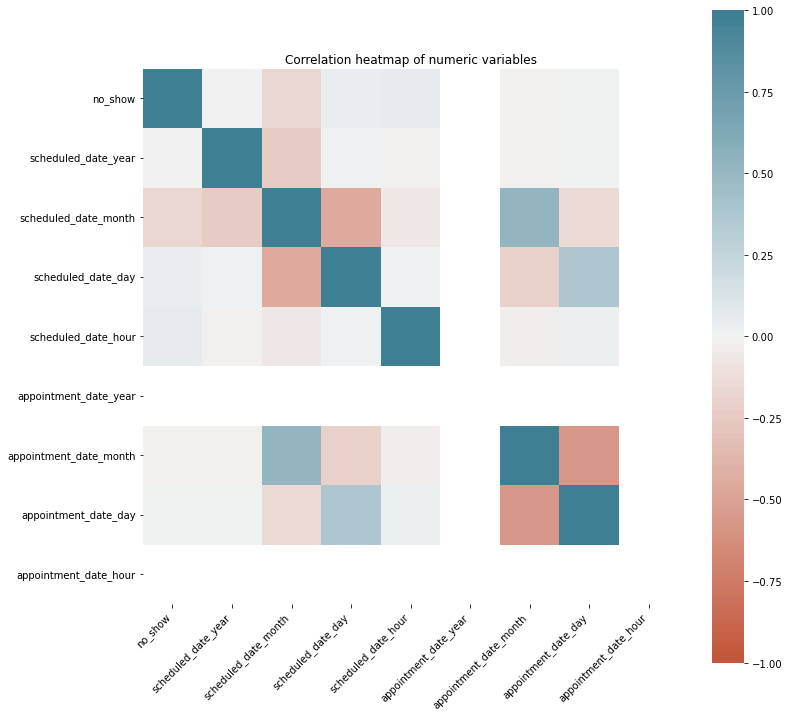

In [561]:
corr = df[['no_show', 'scheduled_date_year', 'scheduled_date_month', 'scheduled_date_day', 'scheduled_date_hour', 'appointment_date_year', 'appointment_date_month', 'appointment_date_day', 'appointment_date_hour']].corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title('Correlation heatmap of numeric variables')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Looks like there is some negative correlation between the scheduled month and no shows. Let's investigate this further.

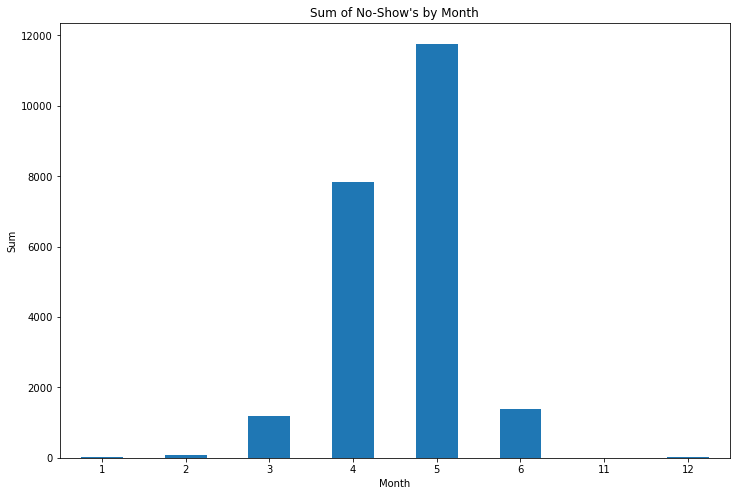

In [572]:
df.groupby('scheduled_date_month').no_show.sum().plot.bar(figsize=(12,8), title='Sum of No-Show\'s by Month', xlabel='Month', ylabel='Sum', rot=0);

As `no_show` is a 0/1 value, it can be summed to show the number of no shows by month, per above. Most no shows occuring in April and May, what is special about those months? Also missing data for July - October

Let's just confirm this below

In [525]:
df.query('scheduled_date_month == 5 and no_show == 1')

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour
3284,327855795244822,F,29,MARIA ORTIZ,0,0,0,0,0,1,1,2016,5,12,10,2016,5,24,0
3303,54416123379516,M,50,MARIA ORTIZ,0,0,0,0,0,0,1,2016,5,16,13,2016,5,16,0
3327,4494549517953,M,58,PRAIA DO CANTO,0,0,0,0,0,0,1,2016,5,20,14,2016,5,31,0
3328,4865334421273,F,34,SANTA LUÍZA,0,0,0,0,0,0,1,2016,5,17,10,2016,5,19,0
3332,2996545563837,F,61,SANTA LÚCIA,0,0,0,0,0,0,1,2016,5,4,14,2016,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110430,49861634253456,F,57,RESISTÊNCIA,0,0,0,0,0,0,1,2016,5,25,9,2016,6,1,0
110442,71679471592828,M,8,RESISTÊNCIA,0,0,0,0,0,1,1,2016,5,16,14,2016,6,6,0
110449,291145987362399,F,12,RESISTÊNCIA,0,0,0,0,0,1,1,2016,5,31,8,2016,6,6,0
110469,832256398961987,F,51,RESISTÊNCIA,0,0,0,0,0,1,1,2016,5,4,7,2016,6,7,0


Lets check the distribution of scheduled_date_month

Text(0, 0.5, 'Count')

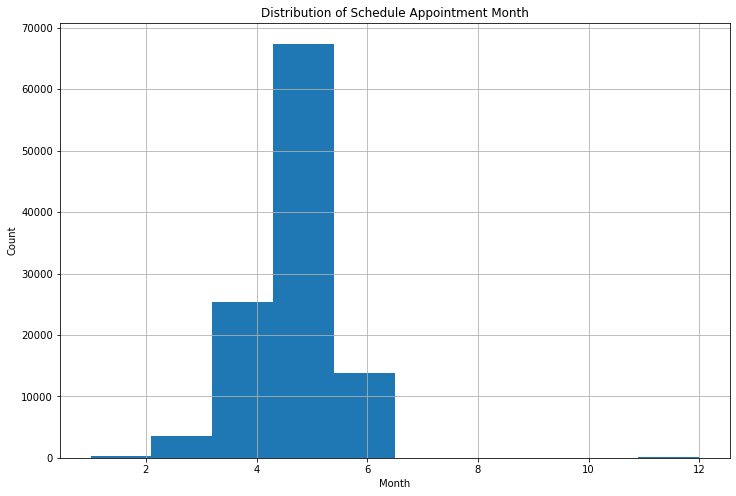

In [573]:
ax = df.scheduled_date_month.hist(figsize=(12,8)) 
ax.set_title('Distribution of Schedule Appointment Month')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

Most appointments are booked in May, so this is why we see most no-shows in May as well. Let's check what proportion of people in May, miss their appointments

In [527]:
df.query('scheduled_date_month == 5').groupby('no_show')['scheduled_date_month'].count()

no_show
0    55652
1    11769
Name: scheduled_date_month, dtype: int64

In [528]:
print(f'Percentage of May no-shows compared to all no shows: {df.query("scheduled_date_month == 5").groupby("no_show")["scheduled_date_month"].count()[1]/22319*100}') 

Percentage of May no-shows compared to all no shows: 52.73085711725436


So we know that 20% of consulations are no shows and 50% of these occur in May, but we don't yet know why.

Let's assess location, gender and age against no shows to see if we can unpack this further

In [529]:
df.head()

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour
0,29872499824296,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016,4,29,18,2016,4,29,0
1,558997776694438,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29,0
2,4262962299951,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29,0
3,867951213174,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016,4,29,17,2016,4,29,0
4,8841186448183,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016,4,29,16,2016,4,29,0


In [530]:
df.query('no_show == 1').groupby("neighbourhood", as_index=False)['no_show'].count().nlargest(n=10, columns='no_show')

,neighbourhood,no_show
38,JARDIM CAMBURI,1465
43,MARIA ORTIZ,1219
36,ITARARÉ,923
58,RESISTÊNCIA,906
10,CENTRO,703
40,JESUS DE NAZARETH,696
39,JARDIM DA PENHA,631
9,CARATOÍRA,591
77,TABUAZEIRO,573
8,BONFIM,550


Text(0, 0.5, 'Count')

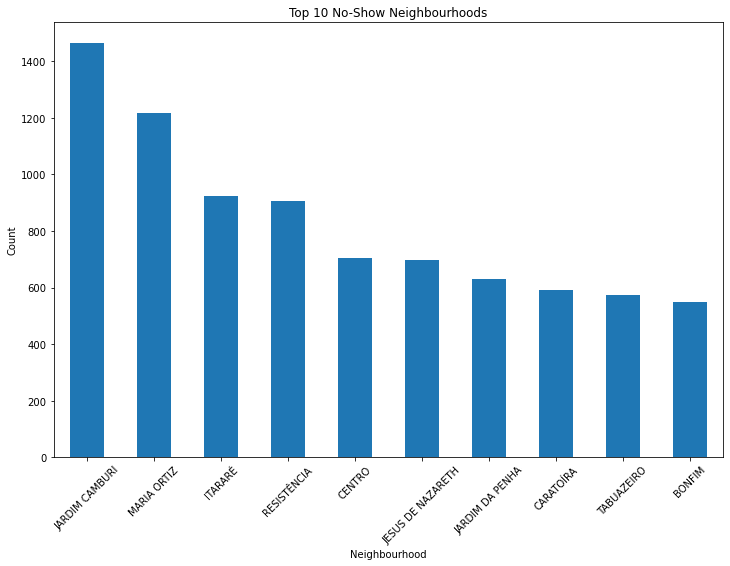

In [577]:
ax = df.query('no_show == 1').groupby("neighbourhood")['no_show'].count().nlargest(n=10).plot.bar(figsize = (12,8), rot=45)
ax.set_title('Top 10 No-Show Neighbourhoods')
ax.set_xlabel('Neighbourhood')
ax.set_ylabel('Count')

Jardim Camburi and Maria Ortiz are the biggest contributors to the no-shows. Is it possible that these hospitals are difficult to reach?

Let's review gender vs no shows now

In [532]:
gender_counts = df.groupby('gender').count()['no_show']
gender_counts

gender
F    71840
M    38687
Name: no_show, dtype: int64

In [533]:
gender_noshow_counts = df.query('no_show == 1').groupby('gender').count()['no_show']
gender_noshow_counts

gender
F    14594
M     7725
Name: no_show, dtype: int64

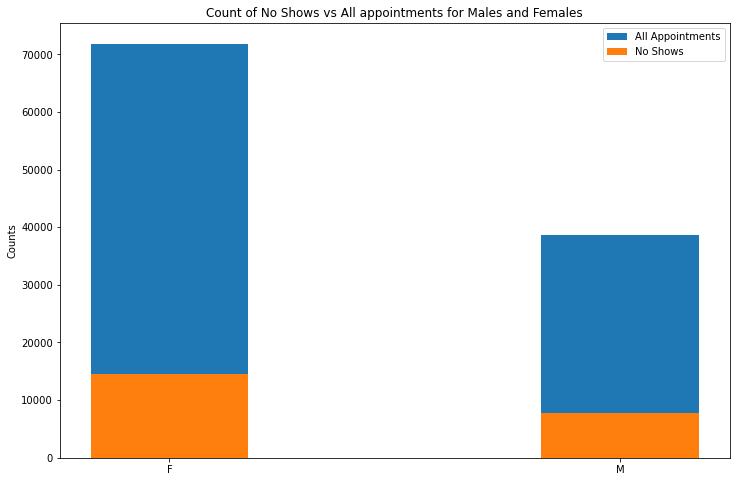

In [534]:
labels = ['F', 'M']
width = 0.35

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(labels, gender_counts, width, label='All Appointments')
ax.bar(labels, gender_noshow_counts, width, label='No Shows')

ax.set_ylabel('Counts')
ax.set_title('Count of No Shows vs All appointments for Males and Females')
ax.legend()

plt.show()

More female no shows, however this seems to correlate with the larger number of females in the data. As such, there doesn't appear to be any useful info here.

Finally, lets review age. Although we saw in the heatmap earlier that age wasn't highly correlated with no show, perhaps if we group age into buckets, we might get a different outcome.

Reference: https://www.absentdata.com/pandas/pandas-cut-continuous-to-categorical/

In [535]:
age_group = pd.cut(df.age,bins=[0,2,17,65,120],labels=['Toddler','Child','Adult','Elderly'], include_lowest=True)
df['age_group'] = age_group
df.head()

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour,age_group
0,29872499824296,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016,4,29,18,2016,4,29,0,Adult
1,558997776694438,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29,0,Adult
2,4262962299951,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29,0,Adult
3,867951213174,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016,4,29,17,2016,4,29,0,Child
4,8841186448183,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016,4,29,16,2016,4,29,0,Adult


In [536]:
df.age_group.value_counts()

Adult      69846
Child      19949
Elderly    13301
Toddler     7431
Name: age_group, dtype: int64

In [537]:
age_groups_counts = df.groupby('age_group').count()['no_show']
age_groups_noshow_counts = df.query('no_show == 1').groupby('age_group').count()['no_show']

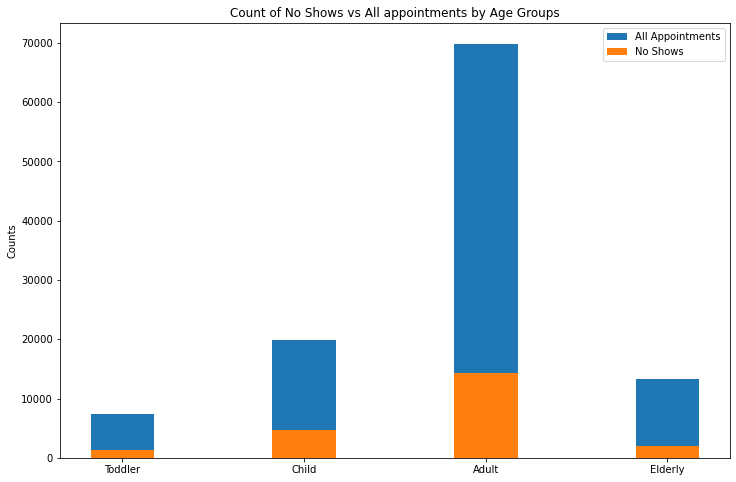

In [538]:
labels = ['Toddler', 'Child', 'Adult', 'Elderly']
width = 0.35

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(labels, age_groups_counts, width, label='All Appointments')
ax.bar(labels, age_groups_noshow_counts, width, label='No Shows')

ax.set_ylabel('Counts')
ax.set_title('Count of No Shows vs All appointments by Age Groups')
ax.legend()

plt.show()

There doesnt appear to be anything unusual here - the no shows vary by age group in relation to the number of overall counts within each age group.

### Research Question 2  - Is there a difference in no-shows between repeat and first-time patients?

To answer this, we'll need to group by `patient_id` where that id occurs more than once. This can then be compared against first-time patients, i.e. those whose `patient_id` only occurs once.

In [539]:
df_repeat = df.loc[df.groupby('patient_id', as_index=False)['patient_id'].agg({'count' : 'count'}).query('count > 1').index]
df_repeat.head()

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour,age_group
7,3449833394123,F,39,GOIABEIRAS,0,0,0,0,0,0,1,2016,4,27,15,2016,4,29,0,Adult
8,56394729949972,F,21,ANDORINHAS,0,0,0,0,0,0,0,2016,4,29,8,2016,4,29,0,Adult
12,566654781423437,F,22,NOVA PALESTINA,1,0,0,0,0,0,0,2016,4,28,11,2016,4,29,0,Adult
14,99884723334928,F,54,NOVA PALESTINA,0,0,0,0,0,0,0,2016,4,28,10,2016,4,29,0,Adult
16,84574392942817,M,50,NOVA PALESTINA,0,0,0,0,0,0,0,2016,4,28,8,2016,4,29,0,Adult


In [540]:
df_first_time = df.loc[df.groupby('patient_id', as_index=False)['patient_id'].agg({'count' : 'count'}).query('count == 1').index]
df_first_time.head()

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_date_year,scheduled_date_month,scheduled_date_day,scheduled_date_hour,appointment_date_year,appointment_date_month,appointment_date_day,appointment_date_hour,age_group
0,29872499824296,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016,4,29,18,2016,4,29,0,Adult
1,558997776694438,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29,0,Adult
2,4262962299951,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29,0,Adult
3,867951213174,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016,4,29,17,2016,4,29,0,Child
4,8841186448183,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016,4,29,16,2016,4,29,0,Adult


In [541]:
df_repeat.shape, df_first_time.shape

((24379, 20), (37920, 20))

In [542]:
df_first_time_no_shows = df_first_time.query('no_show == 1')
df_first_time_no_shows.shape

(8192, 20)

In [543]:
df_repeat_no_shows = df_repeat.query('no_show == 1')
df_repeat_no_shows.shape

(5110, 20)

In [544]:
repeat_proportions = df_repeat_no_shows['no_show'].count() / df_repeat['no_show'].count()
repeat_proportions

0.20960662865581034

In [545]:
first_time_proportions = df_first_time_no_shows['no_show'].count() / df_first_time['no_show'].count()
first_time_proportions

0.2160337552742616

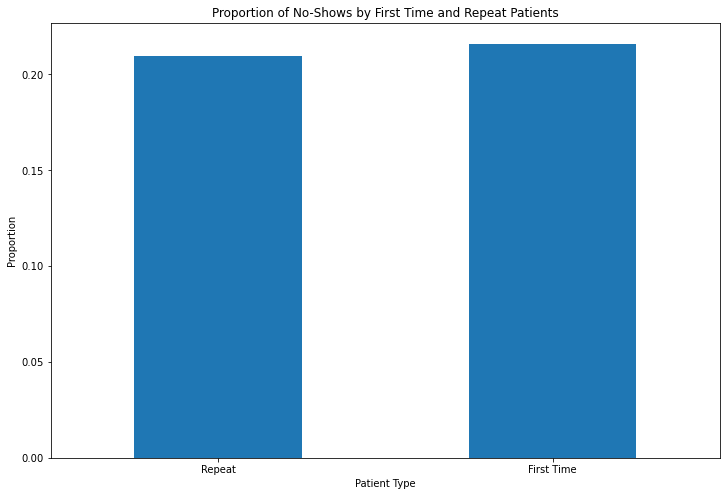

In [547]:
index = ['Repeat', 'First Time']
props = pd.DataFrame([(repeat_proportions), 
                      (first_time_proportions)], 
                     index=index)
props.plot.bar(figsize = (12,8), rot=0, title='Proportion of No-Shows by First Time and Repeat Patients', 
                 xlabel='Patient Type', ylabel='Proportion', legend=False);

Very similar proportion of Repeat and First-Time patients tend to be no shows

Finally, let's save a new version of the dataset since we added an `age_group` categorical field

In [548]:
df.to_csv('cleaned_noshow_appointments_v2.csv', index=False)

<a id='conclusions'></a>
## Conclusions

Our first question was to identify factors that could be influencing no-shows. Based on our analysis we can state the following:

- Around 20% of all scheduled appointments result in no-shows. Scheduled date seems to be the most correlated field with no-shows.
- Most of these occur in April and May with May resulting in 53% of the now-shows.
- Inidividual factors such as diabetes, hypertension, alcoholism and handicap didn't appear to correlate that much with no-shows.
- Small positive correlation between receiving an sms and no shows, this could be explored further.
- Jardim Camburi and Maria Ortiz are the two neighbourhoods with the highest number of no-shows. 
- Women have more appointments scheduled than men and as such, they have more no-shows than men, but not to the extend that it varied from their distribution. 
- By grouping patients into four ages groups - toddler, child, adult and elderly, we could see that adults have the most appointments and no-shows inline with their distribution. Toddler no shows would also be attributed to parents missing those appointments. Elderly might have trouble reaching the hospital, but this needs more investigation.

Our second question was to assess the difference in no shows between first-time and repeat patients. Based on our analysis we can state the following:

- Around 20% of patients are repeat patients. This assumes that the patient_id has been correctly captured on repeat visits, using whatever source system inputs/captures the data.
- Around 22% of first-time patients miss their appointments, versus 21% of repeat patients. As such there isn't too much that can be learned from this difference.



## Limitations

The following are limitations of the current analysis:

- Although we stated that there is a correlation between the schedule date and no-shows, we do not understand what leads to this.
- I's not clear what has led to a few locations having the most numbers of no shows. It may be that they are difficult to reach, at a particlar time of year in particular, but this needs more analysis. 
- We have only identified a few correlations with no shows, but none should be considered a cause.

## Further Analysis

The following could be assessed further:

- Investigation into the locations with the higher number of no shows to undersand what is different/special about them.
- Investigation into events occuring in those regions in April - June in Brazil, as this time period accounts for the majority of no shows.
- Inestigation in the elderly age group to understand if there are particualr reasons that make it harder for them to make their appointments, especilly in the locations with the highest number of no shows.